In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 9]


In [232]:
df_raw = pd.read_csv('data/rssi.csv')

In [ ]:
df = df_raw.copy(deep=True)

In [234]:
# Test with smaller df

# df.head(50000).to_csv('data/rssi_50k.csv')
# df = pd.read_csv('data/rssi_50k.csv')

In [235]:
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
df = df.sort_values(by='DateTime')
df = df.reset_index()
df['ID'] = df.index

In [236]:
# Drop invalid RSSI values

df.loc[(df['A2_RSSI']<1.0), 'A2_RSSI'] = np.nan

In [237]:
# create TourID

df['AreaNumerDif'] = df['AreaNumber'] - df['AreaNumber'].shift(-1) # find new stations
df.loc[df['AreaNumerDif']>0, 'AreaNumerDif'] = 1 # steps between stations always 1 or -1, depending on train direction
df.loc[df['AreaNumerDif']<0, 'AreaNumerDif'] = -1
df['AreaNumerDif'] = df['AreaNumerDif'].replace(0, np.nan) # nan where no change of station
df['AreaNumerDif'] = df['AreaNumerDif'].fillna(method='backfill') # fill with direction of next station change
df['AreaNumerDif'] = df['AreaNumerDif'].fillna(method='ffill') # fill last rows of dataset

df['AreaNumerDifDif'] = df['AreaNumerDif'] - df['AreaNumerDif'].shift(-1) # find shifts of direction
df.loc[df['AreaNumerDifDif']!=0, 'AreaNumerDifDif'] = df.loc[df['AreaNumerDifDif']!=0, 'ID'] # set row id where direction changes
df['AreaNumerDifDif'] = df['AreaNumerDifDif'].replace(0, np.nan) # nan, where no change of direction
df['AreaNumerDifDif'] = df['AreaNumerDifDif'].fillna(method='backfill') # fill with TourID of next TourID
df.rename(columns = {'AreaNumerDifDif':'TourID'}, inplace = True)

In [238]:
# create TrackSegment

df['TrackSegment'] = df['PositionNoLeap'] / 1000
df['TrackSegment'] = df['TrackSegment'].astype(int) # cut last digits

In [240]:
# Create SNR

df['A1_TotalTelDif'] = df['A1_TotalTel'] - df['A1_TotalTel'].shift(1)
df['A1_ValidTelDif'] = df['A1_ValidTel'] - df['A1_ValidTel'].shift(1)
df['SNR'] = df['A1_ValidTelDif'] / df['A1_TotalTelDif']

In [241]:
df_segments = df[['DateTime', 'Latitude', 'Longitude', 'A2_RSSI', 'SNR', 'TourID', 'TrackSegment']]
aggregations = {
    'DateTime': 'first',
    'Latitude': 'mean',
    'Longitude': 'mean',
    'A2_RSSI': 'min',
    'SNR': 'min'}
df_segments = df_segments.groupby(['TrackSegment', 'TourID']).agg(aggregations)

In [320]:
df_segments

DateTime   Latitude  Longitude  A2_RSSI  \
TrackSegment TourID                                                          
97           104798.0   2020-01-22 00:00:01  47.304858   8.049463     1.00   
             142067.0   2020-01-29 05:40:37  47.305277   8.049646     1.88   
             256435.0   2020-01-30 06:49:43  47.305015   8.049532     1.14   
             533060.0   2020-02-04 04:41:01  47.305286   8.049649     2.26   
             574571.0   2020-02-04 07:36:48  47.304984   8.049518     1.00   
...                                     ...        ...        ...      ...   
428          29540868.0 2021-05-25 08:06:27  47.240285   8.189582     2.06   
             29568915.0 2021-05-25 19:04:20  47.240287   8.189581     2.06   
             29851006.0 2021-06-01 07:49:24  47.240293   8.189579     2.30   
             30129424.0 2021-06-09 07:49:02  47.240296   8.189577     2.26   
             30367915.0 2021-06-15 09:19:09  47.240301   8.189576     2.30   

                              SNR   avg_snr  avg_rssi  
TrackSegment TourID                                    
97           104798.0    0.999611       NaN       NaN  
             142067.0    1.000000       NaN       NaN  
             256435.0    0.000000       NaN       NaN  
             533060.0    1.000000       NaN       NaN  
             574571.0    0.000000  0.599922     1.456  
...                           ...       ...       ...  
428          29540868.0  0.999666  0.999679     2.168  
             29568915.0  0.999801  0.999640     2.154  
             29851006.0  0.999068  0.999453     2.154  
             30129424.0  1.000000  0.999593     2.182  
             30367915.0  0.999285  0.999564     2.196  

[1091846 rows x 7 columns]

In [243]:
# df_segments[(df_segments['TourID']==25303)].drop(columns=['TourID', 'DateTime', 'SNR']).droplevel('TourID').to_json('data/segments_example.json', orient="index")

In [244]:
df_segments['avg_snr'] = df_segments['SNR'].rolling(5).mean()
df_segments['avg_rssi'] = df_segments['A2_RSSI'].rolling(5).mean()

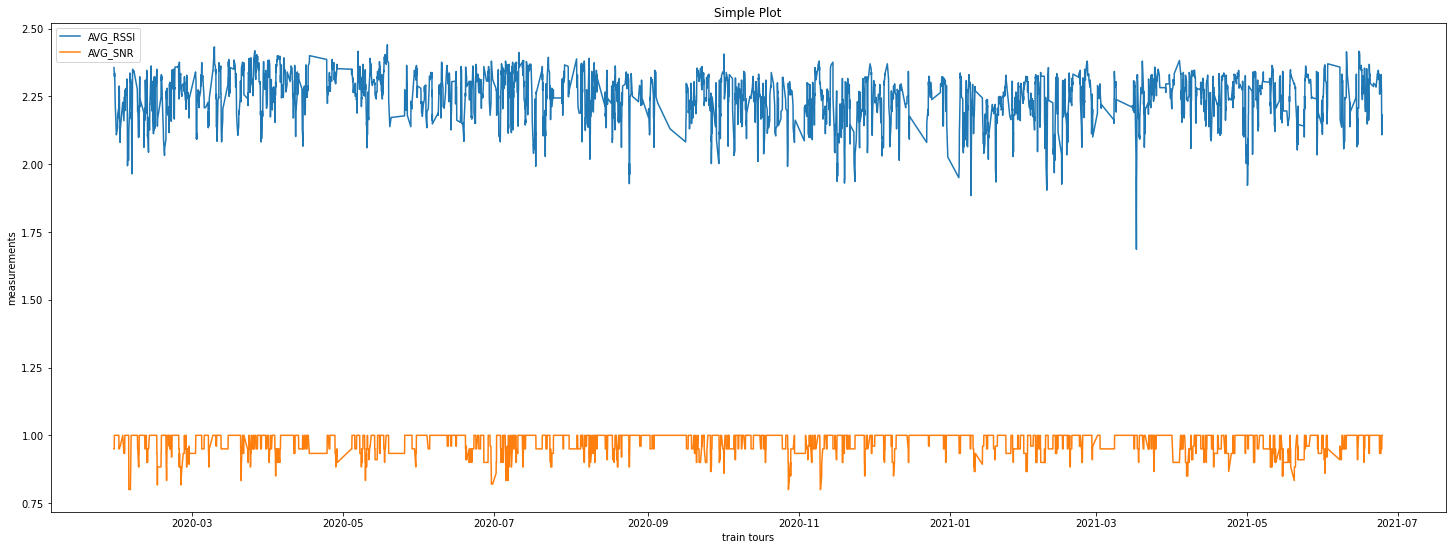

In [331]:
segment_no = 207
x = df_segments.loc[segment_no, 'DateTime']#.iloc[:1000]
avg_snr = df_segments.loc[segment_no, 'avg_snr']#.iloc[:1000]
avg_rssi = df_segments.loc[segment_no, 'avg_rssi']#.iloc[:1000] 
plt.plot(x, avg_rssi, label='AVG_RSSI')  
plt.plot(x, avg_snr, label='AVG_SNR')  
plt.xlabel('train tours')
plt.ylabel('measurements')
plt.title("Simple Plot")
plt.legend()
plt.show() # to suppress last object string

In [315]:
# latest_rssi = df_segments['avg_rssi'].droplevel('TourID').groupby('TrackSegment').last()
# latest_snr = df_segments['avg_snr'].droplevel('TourID').groupby('TrackSegment').last()
# latest_status = latest_rssi * latest_snr
# latest_status.to_json('data/latest_track_status.json', orient="index")

In [321]:
df_segments.to_csv('data/rssi_segmented.csv')